## Hypothesis: Will increase in server capacity increase customer satisfaction and organisation performance?

- there are two approaches to increasing customer satisfaction with regard to waiting time: through decreasing actual waiting time, as well as through enhancing customer’s waiting experience (Katz, Larson, and Larson, 1991; Davis and Heineke, 1994)


-  The objective of queuing analysis and its application in organizations is to “minimize costs” to the organization- both tangible and intangible and increase employee performance towards service delivery. Queuing theory uses queuing models or mathematical models and performance measures to assess and hopefully improve the flow of customers through a queuing system (Gorney, 1981; Bunday,1996;)


### In this project we will aim to decrease customer waiting time to increase customer satisfaction and maximise profit to increase organisation performance

In [1]:
from SimPy.Simulation import *
import random
import numpy as np
import math
import pandas as pd
import scipy.stats as ss

In [2]:
data = pd.read_csv("Cafe_Louis_Data.csv")
data

,Observations,Inter-Arrival Time,Waiting Time,Service Time
0,1,0.00,0.00,51.90
1,2,15.38,43.96,35.75
2,3,68.47,0.00,25.13
3,4,13.09,0.00,33.16
4,5,19.40,11.14,31.19
...,...,...,...,...
246,247,3.85,9.45,38.54
247,248,0.85,44.04,65.76
248,249,10.97,45.04,12.31
249,250,0.59,71.38,102.32


In [3]:
exp_arrival_rate = 1/np.mean(data["Inter-Arrival Time"])
exp_service_rate = 1/np.mean(data["Service Time"])
np.mean(data["Waiting Time"])

66.52059840637455

# Arrivals and Services per hour

In [4]:
arr = 3600 / np.mean(data["Inter-Arrival Time"]) # seconds in an hour divided by the mean arrval in seconds
serv = 3600 / np.mean(data["Service Time"])

print(arr,serv)

130.081581709113 87.16252975834486


# Steady- State Distribution

In [5]:
p = exp_arrival_rate/exp_service_rate
p

1.4924025503821394

## As p > 1 steady-state distribution is not possible and we cannot apply queuing theory for this particular problem. Hence we must make changes to the system to analyse performance measures. This 

## Best Fit Model

In [6]:
# generating random erlang variates using estimated parameters

service = data["Service Time"]

fit_k,fit_loc,fit_scale = ss.erlang.fit(service)

erlang = ss.erlang(fit_k,fit_loc,fit_scale)

erlang.rvs()


/Users/jacobfrench/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  warnings.warn(
/Users/jacobfrench/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  warnings.warn(
/Users/jacobfrench/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  warnings.warn(
/Users/jacobfrench/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:2804: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  warnings.warn(
/Users/jacobfrench/opt/anaconda3/lib/python3.9/site-packag

36.21625013207859

In [7]:
## Model ----------
class Source(Process):
    """generate random arrivals"""
    def run(self, N, lamb):
        for i in range(N):
            a = Arrival(str(i))
            activate(a, a.run())
            t = random.expovariate(lamb)
            yield hold, self, t

class Arrival(Process):
    """an arrival"""
    
    n = 0
    
    def run(self):
        
        Arrival.n += 1
        
        arrivetime = now()
        
        G.numbermon.observe(Arrival.n)
        
        if (Arrival.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)
        
        yield request, self, G.server
        
        t = erlang.rvs() # generates random erlang variate for service time
        
        yield hold, self, t
        yield release, self, G.server
        
        Arrival.n -= 1
        
        G.numbermon.observe(Arrival.n)
        
        if (Arrival.n>0):
            G.busymon.observe(1)
        else:
            G.busymon.observe(0)
        
        delay = now()-arrivetime
        G.delaymon.observe(delay)

class G:
    server = 'dummy'
    delaymon = 'Monitor'
    numbermon = 'Monitor'
    busymon = 'Monitor'

def model(c, N, lamb, maxtime, rvseed):
    # setup
    initialize()
    random.seed(rvseed)
    np.random.seed(rvseed) # set random seed for scipy
    G.server = Resource(c)
    G.delaymon = Monitor()
    G.numbermon = Monitor()
    G.busymon = Monitor()
   
    # simulate
    s = Source('Source')
    activate(s, s.run(N, lamb))
    simulate(until=maxtime)
   
    # gather performance measures
    W = G.delaymon.mean()
    B = G.busymon.timeAverage()
    L = G.numbermon.timeAverage()
    lambeff = L/W
    return (W,B,lambeff)

In [8]:
def conf(L):
    """confidence interval"""
    lower = np.mean(L) - 1.96*np.std(L)/math.sqrt(len(L))
    upper = np.mean(L) + 1.96*np.std(L)/math.sqrt(len(L))
    return (lower,upper)

# Server Capacity = 1 

In [9]:
p = exp_arrival_rate/exp_service_rate
p

1.4924025503821394

### Steady-State not possible

In [10]:
allW1 = []
allB1 = []
allLambeff1 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=1, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)   # added np seed for erlang
    
    allW1.append(result[0])
    allB1.append(result[1])
    allLambeff1.append(result[2])

print("Estimate of time in system:", np.mean(allW1))
print("Conf int of time in system:", conf(allW1))
print("Estimate of rho:", np.mean(allB1))
print("Conf int of rho:", conf(allB1))
print("Estimate of lambeff:",np.mean(allLambeff1))
print("Conf int of time in system:", conf(allLambeff1))

Estimate of time in system: 6958.134254397854
Conf int of time in system: (6775.370413294764, 7140.898095500945)
Estimate of rho: 0.9991322803859244
Conf int of rho: (0.998812996097153, 0.9994515646746958)
Estimate of lambeff: 0.024199092142278042
Conf int of time in system: (0.024063534198174856, 0.024334650086381228)


## Server Capacity = 2

In [11]:
p = exp_arrival_rate/(2*exp_service_rate)
p

0.7462012751910697

### Steady-State possible

In [12]:
allW2 = []
allB2 = []
allLambeff2 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=2, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)
    
    allW2.append(result[0])
    allB2.append(result[1])
    allLambeff2.append(result[2])
    

print("Estimate of time in system:", np.mean(allW2))
print("Conf int of time in system:", conf(allW2))
print("Estimate of rho:", np.mean(allB2))
print("Conf int of rho:", conf(allB2))
print("Estimate of lambeff:",np.mean(allLambeff2))
print("Conf int of time in system:", conf(allLambeff2))

Estimate of time in system: 77.16223903124472
Conf int of time in system: (74.60818133001284, 79.71629673247661)
Estimate of rho: 0.8617629298280671
Conf int of rho: (0.8574184082680584, 0.8661074513880759)
Estimate of lambeff: 0.036297298821234135
Conf int of time in system: (0.03597878108982303, 0.03661581655264524)


## Server Capacity = 3

In [13]:
p = exp_arrival_rate/(3*exp_service_rate)
p

0.4974675167940465

### Steady-State possible

In [14]:
allW3 = []
allB3 = []
allLambeff3 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=3, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)
    
    allW3.append(result[0])
    allB3.append(result[1])
    allLambeff3.append(result[2])

print("Estimate of time in system:", np.mean(allW3))
print("Conf int of time in system:", conf(allW3))
print("Estimate of rho:", np.mean(allB3))
print("Conf int of rho:", conf(allB3))
print("Estimate of lambeff:",np.mean(allLambeff3))
print("Conf int of time in system:", conf(allLambeff3))

Estimate of time in system: 45.967077752808585
Conf int of time in system: (45.50495330070013, 46.42920220491704)
Estimate of rho: 0.7935100343462015
Conf int of rho: (0.7898027574679072, 0.7972173112244958)
Estimate of lambeff: 0.03633295725153752
Conf int of time in system: (0.036013200596462645, 0.03665271390661239)


## Server Capacity = 4

In [15]:
allW4 = []
allB4 = []
allLambeff4 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=4, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)
    
    allW4.append(result[0])
    allB4.append(result[1])
    allLambeff4.append(result[2])
    

print("Estimate of time in system:", np.mean(allW4))
print("Conf int of time in system:", conf(allW4))
print("Estimate of rho:", np.mean(allB4))
print("Conf int of rho:", conf(allB4))
print("Estimate of lambeff:",np.mean(allLambeff4))
print("Conf int of time in system:", conf(allLambeff4))

Estimate of time in system: 42.22149097321664
Conf int of time in system: (41.94950649428369, 42.49347545214959)
Estimate of rho: 0.7809848128293219
Conf int of rho: (0.7772434589510843, 0.7847261667075595)
Estimate of lambeff: 0.03633742388848227
Conf int of time in system: (0.03601685526816689, 0.03665799250879764)


## Server Capacity = 5

In [16]:
allW5 = []
allB5 = []
allLambeff5 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=5, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)
    
    allW5.append(result[0])
    allB5.append(result[1])
    allLambeff5.append(result[2])
    

print("Estimate of time in system:", np.mean(allW5))
print("Conf int of time in system:", conf(allW5))
print("Estimate of rho:", np.mean(allB5))
print("Conf int of rho:", conf(allB5))
print("Estimate of lambeff:",np.mean(allLambeff5))
print("Conf int of time in system:", conf(allLambeff5))

Estimate of time in system: 41.49646975796606
Conf int of time in system: (41.258694586758935, 41.73424492917319)
Estimate of rho: 0.7788890804870112
Conf int of rho: (0.7751747880065151, 0.7826033729675074)
Estimate of lambeff: 0.036337424814328126
Conf int of time in system: (0.03601685599365065, 0.036657993635005603)


## Capacity = 6

In [17]:
allW6 = []
allB6 = []
allLambeff6 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=6, N=1000, lamb=exp_arrival_rate,
                   maxtime=100000000, rvseed=seed)
    
    allW6.append(result[0])
    allB6.append(result[1])
    allLambeff6.append(result[2])
    

print("Estimate of time in system:", np.mean(allW6))
print("Conf int of time in system:", conf(allW6))
print("Estimate of rho:", np.mean(allB6))
print("Conf int of rho:", conf(allB6))
print("Estimate of lambeff:",np.mean(allLambeff6))
print("Conf int of time in system:", conf(allLambeff6))

Estimate of time in system: 41.34414068587694
Conf int of time in system: (41.11301077242758, 41.575270599326295)
Estimate of rho: 0.7784657005391263
Conf int of rho: (0.7747596522429313, 0.7821717488353214)
Estimate of lambeff: 0.03633742481432813
Conf int of time in system: (0.036016855993650655, 0.03665799363500561)


## Server Capacity = 10

In [18]:
allW10 = []
allB10 = []
allLambeff10 = []
    
for k in range(50):
    seed = 123*k
    result = model(c=10, N=1000, lamb=exp_arrival_rate,
                   maxtime=1000000000, rvseed=seed)
    
    allW10.append(result[0])
    allB10.append(result[1])
    allLambeff10.append(result[2])
    

print("Estimate of time in system:", np.mean(allW10))
print("Conf int of time in system:", conf(allW10))
print("Estimate of rho:", np.mean(allB10))
print("Conf int of rho:", conf(allB10))
print("Estimate of lambeff:",np.mean(allLambeff10))
print("Conf int of time in system:", conf(allLambeff10))

Estimate of time in system: 41.30520113634134
Conf int of time in system: (41.07442722739635, 41.53597504528633)
Estimate of rho: 0.7784101303543552
Conf int of rho: (0.7746906811920995, 0.782129579516611)
Estimate of lambeff: 0.03633742481432813
Conf int of time in system: (0.036016855993650655, 0.03665799363500561)


# Results

## Capacity 1

For our initial model we Cafe Louis had an arrival rate of 130.86 customers per hour, however they were only serving 87.162 customers per hour.

This results in a utilisation factor greater than 1. This causes waiting time to tend to infinity, hence we will have very poor customer satisfaction. This also means we cannot gather performance measures from our simulations

Also this will result in poor organisation performance. As if the estimated spend is 5 the cafe will be able to earn 87.162 * 5 = 435.81 dollars per hour. However as arrivals exceed service 130.86 - 87.162 = 43.698 customers will not be served an hour. This will result in loses of 5 * 43.698 = 218.49 per hour. This implies poor organisation performance.

Assume a server is payed minimum wage (22.70 an hour) then profit (excluding cost of production) = 435.81 - 22.7 = 413.11 per hour

## Capacity 2

Steady-state is attainable if server capacity is greater than 2. This means we can now simulate and make use of performance measures.

Simulation 2 calculates lambeff = 0.036297 and rho = 0.86176, using these values service rate can be calcualate as 151.6311 per hour.

This new service rate allows for all 130.86 arrivals per hour to be served. Hence earnings are equal to 130.86 * 5 = 654.3 per hour. This implies better organisational performance.

How ever as we now have 2 servers cost of wages is 2 * 22.70 = 45.40 per hour.

As our utilisation factor is below one now. There is a portion of time where our system is idle this is equal to 1 - 0.86176 = 0.13284. Hence 13.824% of the time the system is idle yet wages are still being paid. The amounted of excess wages are 2 * 22.70 * 0.13284 = $6.0309 per hour.


Total profit = 654.3 - 45.40 = 608.90 per hour.


Expected waiting time has a significant decrease from infinity to 77.16223903124472. This will provide a significant increase in customer satisfaction.

## Capacity 3

Simulation 3 calculates lambeff = 0.036297 and rho = 0.7935, using these values service rate can be calcualted as 164.672 per hours.

As expected all arrivals per hour will be served.

However now we have 3 servers so cost of wages is 3 * 22.70 = 68.1 per hour.

We see a further decrease in utilisation factor to 0.7935. This implies the system will be idle (1-0.7935 = 0.2065) 20.65% of the time. Excess wages:  68.1 * 0.2095 = 14.26695 per hour.

Total profit = 654.3 - 68.1 = 586.2 per hour. We see a decrease in profit per hour.

Expected waiting time has a 40.4% decrease to 45.967077752808585. This will still provide significant increase in customer satisfaction.

## Capacity 4

Simulation 3 calculates lambeff = 0.036297 and rho = 0.7809848128293219, using these values service rate can be calcualted as 167.314 per hours.

As expeceted all arrivals per hour will be served

Cost of wages = 4 * 22.70 = 90.80

We see further decrease in utilisation factor to 0.7809. This implies system will be idle (1-0.78090 = 0.2191) 21.191% of the time. Excess wages: 90.8 * 0.21292 = 19.333

Total profit = 654.3 - 90.80 = 563.5 per hour. We see a further decrease in profit per hour

Expected waiting time decrease of 8.14% from 45.9670 to 42.2214. This will not provide a significant increase in customer satisfaction


# Capacity > 4

We will continue to see profit decreasing by 22.70 for each server added and small non significant decreases in waiting times.

## Plots

## Waiting Time vs No. of Servers (including server 1)

/var/folders/j5/hf4njz5j1230dgtm2gwzfjrc0000gn/T/ipykernel_41444/1731335313.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


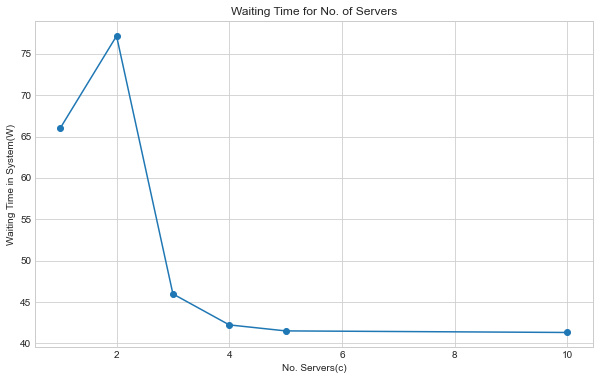

In [19]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

wait = [66,np.mean(allW2),np.mean(allW3),np.mean(allW4),np.mean(allW5),np.mean(allW10)]
c = [1,2,3,4,5,10]

plt.xlabel("No. Servers(c)")
plt.ylabel("Waiting Time in System(W)")
plt.title("Waiting Time for No. of Servers")
plt.plot(c,wait,marker="o")


## Excluding Server 1

/var/folders/j5/hf4njz5j1230dgtm2gwzfjrc0000gn/T/ipykernel_41444/758559840.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


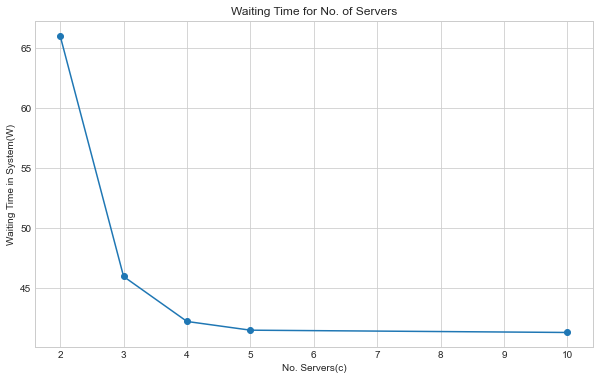

In [23]:
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

wait = [66,np.mean(allW3),np.mean(allW4),np.mean(allW5),np.mean(allW10)]
c = [2,3,4,5,10]

plt.xlabel("No. Servers(c)")
plt.ylabel("Waiting Time in System(W)")
plt.title("Waiting Time for No. of Servers")
plt.plot(c,wait,marker="o")


# Profit vs No. of Servers

/var/folders/j5/hf4njz5j1230dgtm2gwzfjrc0000gn/T/ipykernel_41444/1179548147.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


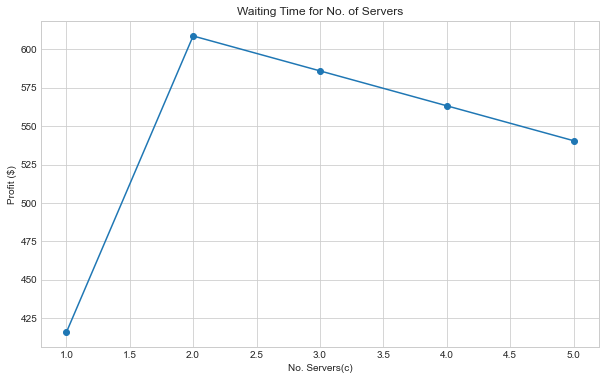

In [21]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

c = [1,2,3,4,5]
profit = [415.81,608.6,585.9,563.2,540.5]



plt.xlabel("No. Servers(c)")
plt.ylabel("Profit ($)")
plt.title("Waiting Time for No. of Servers")
plt.plot(c,profit,marker="o")

## Waiting Time and Profit Trade Off

/var/folders/j5/hf4njz5j1230dgtm2gwzfjrc0000gn/T/ipykernel_41444/1809247904.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


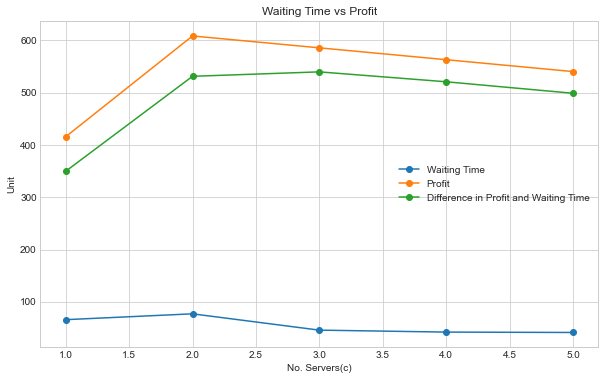

In [28]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

wait = [66,np.mean(allW2),np.mean(allW3),np.mean(allW4),np.mean(allW5)] # setting mean waiting time c = 1 to 1000 to observe trend it should be infinite
c = [1,2,3,4,5]
profit = [415.81,608.6,585.9,563.2,540.5]

diff = [np.abs(wait[i] - profit[i]) for i in range(len(wait))]
plt.xlabel("No. Servers(c)")
plt.ylabel("Unit")
plt.title("Waiting Time vs Profit")
plt.plot(c,wait,marker="o",label="Waiting Time")
plt.plot(c,profit,marker="o",label="Profit")
plt.plot(c,diff,marker="o",label="Difference in Profit and Waiting Time")
plt.legend()
plt.savefig('tradeoff.pdf')

/var/folders/j5/hf4njz5j1230dgtm2gwzfjrc0000gn/T/ipykernel_41444/3730103123.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


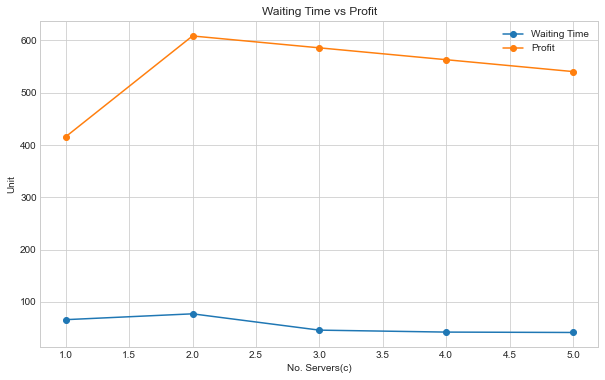

In [27]:
plt.style.use('seaborn-whitegrid')

plt.figure(figsize=(10,6))

wait = [66,np.mean(allW2),np.mean(allW3),np.mean(allW4),np.mean(allW5)] # setting mean waiting time c = 1 to 1000 to observe trend it should be infinite
c = [1,2,3,4,5]
profit = [415.81,608.6,585.9,563.2,540.5]

diff = [np.abs(wait[i] - profit[i]) for i in range(len(wait))]
plt.xlabel("No. Servers(c)")
plt.ylabel("Unit")
plt.title("Waiting Time vs Profit")
plt.plot(c,wait,marker="o",label="Waiting Time")
plt.plot(c,profit,marker="o",label="Profit")
plt.legend()
plt.savefig('tradeoff1.pdf')

## Plot Interpretation

- Waiting time vs no. of servers shows that we will always see a decrease in service time if more servers are added
- Profit vs no. of server shows that we will see an increase in profit for 2 servers any number greater will result in decrease in profit.
- Waiting Time and Profit Trade Off shows that profit maximised at c=2 however waiting time is optimised at largest c

# Conclusion

We can increase customer satisfaction and organisation performance by increasing server capacity. Customer satisfaction is always increased as server capacity is increased as this results in decreased waiting time. Organisation performance is increased when c=2 as this is the point where profit is maximised increasing server capacity results in a decrease in profit hence organisation performance. However finding a balance of customer satisfaction and organisation performance is important. 

## Recommendations

I would recommend that cafe louis hire 1-3 more staff to work between 11-2pm on weekdays. Hiring one additional staff member will increase profit by 47.77% maximising their organisation performance. How adding an additional 2 staff will increase customer satisfaction by 40% whilst for going 22.70 profit and adding 3 staff will increase customer satisfaction by 8% whilst for going 45.40 profit. Any additional staff will not increase customer satisfaction significantly.